In [1]:
import os
import cv2
import time
import json
import joblib
import pandas as pd
import numpy as np

import imageio
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

import keras
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.applications.vgg16 import VGG16, preprocess_input
# from keras.applications.mobilenet_v3 import MobileNetV3Large, preprocess_input

2024-05-01 17:17:51.543986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 17:17:51.853846: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 17:17:52.899832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bmarghescu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2024-05-01 17:17:52.899957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugi

In [2]:
DATASET_DIR = "Datasets/Converted Datasets/EmoDB"
SPECTROGRAM_DIR = "Spectrograms/EmoDB_Separate_Speakers_v3/Converted_Log"
TF_RECORDS_DIR = "TFRecords/EmoDB_Separate_Speakers_v3_VGG16"
TF_RECORDS_NAME = "EmoDB_Separate_Speakers_v3_converted_log_VGG16.tfrecords"
MODEL_DIR = "Models"
MODEL_NAME = "EmoDB_Separate_Speakers_v3_converted_log_VGG16.h5"
NUM_CLASSES = 7
SAMPLE_RATE = 8000
BATCH_SIZE = 32
EPOCHS = 13
RANDOM_SEED = 42

In [3]:
def create_dataframe_emodb():
    EMOTION_DICT_EMODB = {'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
    if DATASET_DIR != "Datasets/EmoDB" and DATASET_DIR != "Datasets/Converted Datasets/EmoDB":
        raise Exception("DATASET_DIR must be set to 'Datasets/EmoDB' or 'Datasets/Converted Datasets/EmoDB' for EmoDB dataset")
    file_person, file_gender, file_emotion, file_path = [], [], [], []
    file_list = os.listdir(DATASET_DIR)
    for file in file_list:
        person = int(file[0:2])
        gender = 'male' if person in [3, 10, 11, 12, 15] else 'female'
        emotion = EMOTION_DICT_EMODB[file[5]]
        file_person.append(person)
        file_gender.append(gender)
        file_emotion.append(emotion)
        file_path.append(os.path.join(DATASET_DIR, file))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'path': file_path}
    emodb_df = pd.DataFrame(file_dict)
    return emodb_df

In [4]:
def create_dataframe_emodb_separate_speakers_mixed():
    EMOTION_DICT_EMODB = {'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
    if DATASET_DIR != "Datasets/EmoDB" and DATASET_DIR != "Datasets/Converted Datasets/EmoDB":
        raise Exception("DATASET_DIR must be set to 'Datasets/EmoDB' or 'Datasets/Converted Datasets/EmoDB' for EmoDB dataset")
    file_person, file_gender, file_emotion, file_path = [], [], [], []
    file_list = os.listdir(DATASET_DIR)
    for file in file_list:
        person = int(file[0:2])
        gender = 'male' if person in [3, 10, 11, 12, 15] else 'female'
        emotion = EMOTION_DICT_EMODB[file[5]]
        file_person.append(person)
        file_gender.append(gender)
        file_emotion.append(emotion)
        file_path.append(os.path.join(DATASET_DIR, file))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'path': file_path}
    emodb_df = pd.DataFrame(file_dict)
    emodb_df_male = emodb_df[emodb_df['gender'] == 'male']
    emodb_df_female = emodb_df[emodb_df['gender'] == 'female']
    male_dfs = [group for _, group in emodb_df_male.groupby('person')]
    female_dfs = [group for _, group in emodb_df_female.groupby('person')]
    from random import shuffle, seed
    seed(RANDOM_SEED)
    shuffle(male_dfs)
    shuffle(female_dfs)
    return male_dfs, female_dfs

In [5]:
def create_dataframe_emoiit():
    if DATASET_DIR != "Datasets/EMO-IIT" and DATASET_DIR != "Datasets/Converted Datasets/EMO-IIT":
        raise Exception("DATASET_DIR must be set to 'Datasets/EMO-IIT' or 'Datasets/Converted Datasets/EMO-IIT' for EMO-IIT dataset")
    file_emotion, file_path = [], []
    emotion_dir_list = os.listdir(DATASET_DIR)
    for emotion_dir in emotion_dir_list:
        file_list = os.listdir(os.path.join(DATASET_DIR, emotion_dir))
        for file in file_list:
            if file.endswith('.wav'):
                file_emotion.append(emotion_dir)
                file_path.append(os.path.join(DATASET_DIR, emotion_dir, file))
    file_dict = {'emotion': file_emotion, 'path': file_path}
    emoiit_df = pd.DataFrame(file_dict)
    emoiit_df = pd.DataFrame(shuffle(emoiit_df, random_state=RANDOM_SEED), columns=emoiit_df.columns).reset_index(drop=True, inplace=False)
    return emoiit_df

In [6]:
def create_dataframe_emoiit_separate_speakers_mixed():
    genders = ["male", "female"]
    file_emotion, file_speaker_id, file_gender, file_path = [], [], [], []
    for gender in genders:
        for emotion_dir in os.listdir(os.path.join(DATASET_DIR, gender)):
            for file in os.listdir(os.path.join(DATASET_DIR, gender, emotion_dir)):
                if file.endswith(".wav"):
                    speaker_id = file[:5] if file[:4].lower() == "b511" else file[:4].lower()
                    file_emotion.append(emotion_dir)
                    file_speaker_id.append(speaker_id)
                    file_gender.append(gender)
                    file_path.append(os.path.join(DATASET_DIR, gender, emotion_dir, file))
    emoiit_df = pd.DataFrame({'emotion': file_emotion, 'speaker_id': file_speaker_id, 'gender': file_gender, 'path': file_path}).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    emoiit_df_male = emoiit_df[emoiit_df['gender'] == 'male']
    emoiit_df_female = emoiit_df[emoiit_df['gender'] == 'female']

    def process_dataframe_gender_separated(emoiit_df):
        common_speakers = set.intersection(*[set(emoiit_df[emoiit_df['emotion'] == emotion]['speaker_id'].unique()) for emotion in emoiit_df['emotion'].unique() if emotion != 'irritation'])
        common_speakers_list = list(common_speakers)
        emoiit_df_common_speakers = emoiit_df[emoiit_df['speaker_id'].isin(common_speakers_list)]
        emoiit_df_common_speakers_dict = {speaker: emoiit_df_common_speakers[emoiit_df_common_speakers['speaker_id'] == speaker].reset_index(drop=True) for speaker in common_speakers_list}
        emoiit_df_irritation = emoiit_df[emoiit_df['emotion'] == 'irritation'].sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        num_parts = len(common_speakers_list)
        emoiit_df_irritation_parts = [emoiit_df_irritation[i:i + len(emoiit_df_irritation) // num_parts] for i in range(0, len(emoiit_df_irritation), len(emoiit_df_irritation) // num_parts)]
        return [pd.concat([emoiit_df_common_speakers_dict[common_speakers_list[i]], emoiit_df_irritation_parts[i]], ignore_index=True).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True) for i in range(len(common_speakers_list))]
    
    parts_male = process_dataframe_gender_separated(emoiit_df_male)
    parts_female = process_dataframe_gender_separated(emoiit_df_female)

    min_len_parts_list = min(len(parts_female), len(parts_male))
    # sort by length of parts
    parts_male = sorted(parts_male, key=len, reverse=True)[:min_len_parts_list]
    parts_female = sorted(parts_female, key=len, reverse=True)[:min_len_parts_list]
    
    from random import shuffle, seed
    seed(RANDOM_SEED)
    shuffle(parts_male)
    shuffle(parts_female)

    return parts_male, parts_female

In [7]:
def create_dataframe_ravdess():
    emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    if DATASET_DIR != "Datasets/RAVDESS/audio_speech_actors_01-24" and DATASET_DIR != "Datasets/Converted Datasets/RAVDESS":
        raise Exception("DATASET_DIR must be set to 'Datasets/RAVDESS/audio_speech_actors_01-24' or 'Datasets/Converted Datasets/RAVDESS' for RAVDESS dataset")
    file_person, file_gender, file_emotion, file_intensity, file_path = [], [], [], [], []
    person_dir_list = os.listdir(DATASET_DIR)
    for person_dir in person_dir_list:
        if person_dir.startswith("Actor_"):
            person = int(person_dir.split("_")[1])
            file_list_person = os.listdir(os.path.join(DATASET_DIR, person_dir))
            for file in file_list_person:
                if file.endswith(".wav"):
                    file_person.append(person)
                    file_path.append(os.path.join(DATASET_DIR, person_dir, file))
                    file_gender.append("male" if person % 2 == 1 else "female")
                    file_emotion.append(emotion_list[int(file.split("-")[2]) - 1])
                    file_intensity.append(int(file.split("-")[3].split(".")[0]))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'intensity': file_intensity, 'path': file_path}
    ravdess_df = pd.DataFrame(file_dict)
    ravdess_df = pd.DataFrame(shuffle(ravdess_df, random_state=RANDOM_SEED), columns=ravdess_df.columns).reset_index(drop=True, inplace=False)
    return ravdess_df

In [8]:
def preprocess_dataset(ser_df, dataset_type, ohe=None, fold=None):
    audio_block_list = []
    emotion_list = []
    for row in tqdm(ser_df.itertuples(), desc=f"Preprocessing audio files dataset - {dataset_type}", total=len(ser_df)):
        data, _ = librosa.load(row.path, sr=SAMPLE_RATE)
        if data.shape[0] < SAMPLE_RATE:
            data = np.pad(data, (0, SAMPLE_RATE - data.shape[0]), 'constant')
        frames = librosa.util.frame(data, frame_length=SAMPLE_RATE, hop_length=int(SAMPLE_RATE/100)).T
        for frame in frames:
            audio_block_list.append(frame)
            emotion_list.append(row.emotion)
    audio_block_list = np.array(audio_block_list)
    emotion_list = np.array(emotion_list)
    if ohe is None:
        ohe = OneHotEncoder(categories='auto', sparse=False)
        emotion_list = ohe.fit_transform(emotion_list[:, np.newaxis])
        ohe_path = os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_ohe.pkl")) if fold is not None else os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", "_ohe.pkl"))
        joblib.dump(ohe, ohe_path)
    else:
        emotion_list = ohe.transform(emotion_list[:, np.newaxis])
    return audio_block_list, emotion_list

In [9]:
def create_spectrogram_log(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(Xdb))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [10]:
def create_spectrogram_linear(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=np.amin(X), vmax=np.amax(X))
    image = cmap(norm(X))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [11]:
def create_spectrogram_mel(data, sr):
    Xmel = np.abs(librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    X_mel_db = librosa.amplitude_to_db(Xmel, ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(X_mel_db))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [12]:
def create_spectrogram_hpss(data, sr):
    X = librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4))
    X_harmonic, X_percussive = librosa.decompose.hpss(X)
    X_db = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    X_harmonic_db = librosa.amplitude_to_db(np.abs(X_harmonic), ref=np.max)
    X_percussive_db = librosa.amplitude_to_db(np.abs(X_percussive), ref=np.max)
    image = np.hstack((X_db, X_harmonic_db, X_percussive_db))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(image))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [13]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [14]:
def create_example_train(image, path, emotion_id):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [15]:
def create_example_test(image, path, emotion_id, sample_weight):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
        "sample_weight": float_feature(sample_weight),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [16]:
def parse_tfrecord_train(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example


def parse_tfrecord_test(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
        "sample_weight": tf.io.FixedLenFeature([1], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example

In [17]:
def create_spectrogram_dataset(audio_block_list, emotion_list, tf_records_name, spectrogram_dir, sr, create_spectrogram, sample_weight=None, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    if not os.path.exists(os.path.join(TF_RECORDS_DIR, dataset_type)):
        os.makedirs(os.path.join(TF_RECORDS_DIR, dataset_type))
    with tf.io.TFRecordWriter(os.path.join(TF_RECORDS_DIR, dataset_type, tf_records_name)) as writer:
        for index, block in enumerate(tqdm(audio_block_list, desc=f"Creating Spectrogram Dataset - {dataset_type}", total=audio_block_list.shape[0])):
            image = create_spectrogram(block, sr)
            if not os.path.exists(os.path.join(spectrogram_dir, dataset_type)):
                os.makedirs(os.path.join(spectrogram_dir, dataset_type))
            image_path = os.path.join(spectrogram_dir, dataset_type, f"{index:05d}.png")
            imageio.imsave(image_path, image)
            image = tf.io.decode_png(tf.io.read_file(image_path))
            if dataset_type == "train":
                example = create_example_train(image, image_path, emotion_list[index])
            else:
                if sample_weight is None:
                    raise ValueError("sample_weight must be provided for test dataset")
                else:
                    example = create_example_test(image, image_path, emotion_list[index], np.expand_dims(sample_weight[index], axis=0))
            writer.write(example.SerializeToString())

In [18]:
def prepare_sample_train(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    return image, features["emotion_id"]


def prepare_sample_test(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    sample_weight = tf.squeeze(features["sample_weight"])
    return image, features["emotion_id"], sample_weight

In [19]:
def get_dataset(filename, batch_size, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    AUTOTUNE = tf.data.AUTOTUNE
    if dataset_type == "train":
        dataset = (
            tf.data.TFRecordDataset(filename, num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_train, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_train, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    else:
        dataset = (
            tf.data.TFRecordDataset(filename, num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_test, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_test, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    return dataset

In [20]:
def create_ser_model():
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        vgg16 = VGG16(weights="imagenet")
        model = Model(inputs=vgg16.input, outputs=Dense(NUM_CLASSES, activation="softmax", name="emotion")(vgg16.get_layer("fc2").output))
        # mobilenetv3_large = MobileNetV3Large(weights="imagenet")
        # model = Model(inputs=mobilenetv3_large.input, outputs=Dense(NUM_CLASSES, activation="softmax", name="emotion")(mobilenetv3_large.layers[-2].output))
        optimizer = tf.optimizers.SGD(learning_rate=0.0001, decay=0.0001, momentum=0.9)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
        return model

In [21]:
def plot_history(history, model_name):
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    fig.suptitle(model_name, size=20)
    axs[0].plot(history.history['loss'])
    axs[0].title.set_text('Training Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[1].plot(history.history['accuracy'])
    axs[1].title.set_text('Training Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    plt.show()

In [22]:
def plot_training_curve(model_name):
    history_json = json.load(open(os.path.join(MODEL_DIR, model_name.replace(".h5", ".json")), "r"))
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['weighted_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Weighted Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [23]:
def get_run_logdir(root_logdir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [24]:
ser_df_male_parts, ser_df_female_parts = create_dataframe_emodb_separate_speakers_mixed()
# strategy = tf.distribute.MirroredStrategy()
# num_gpus = strategy.num_replicas_in_sync


Fold 1:


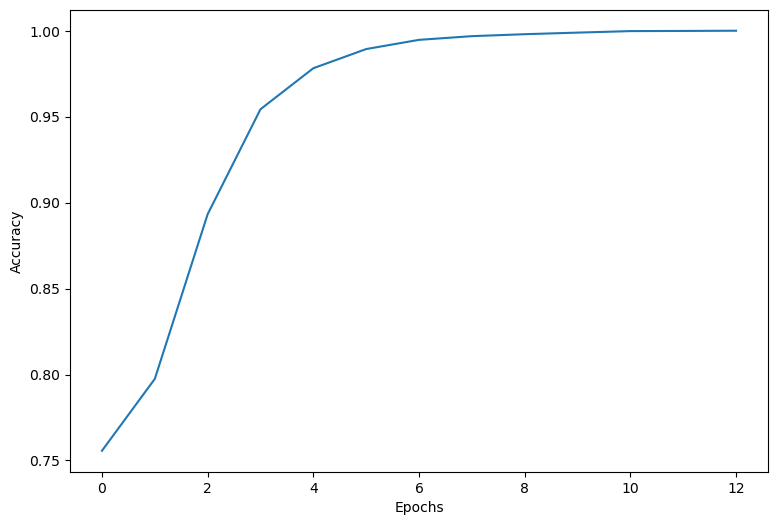

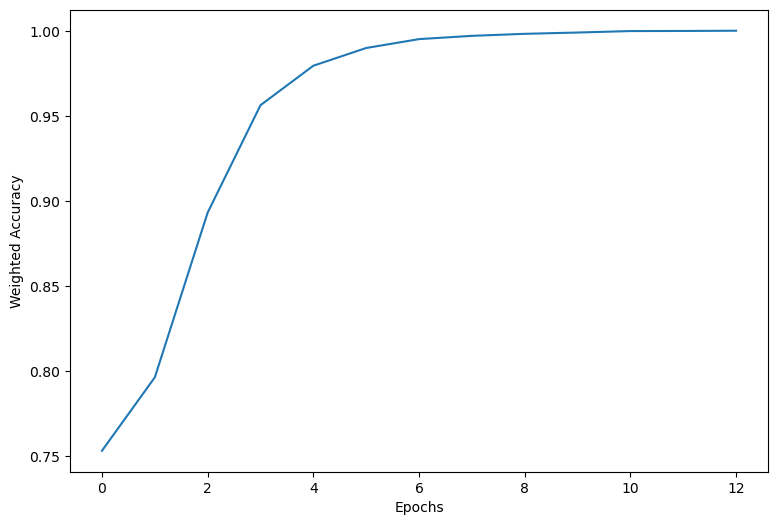

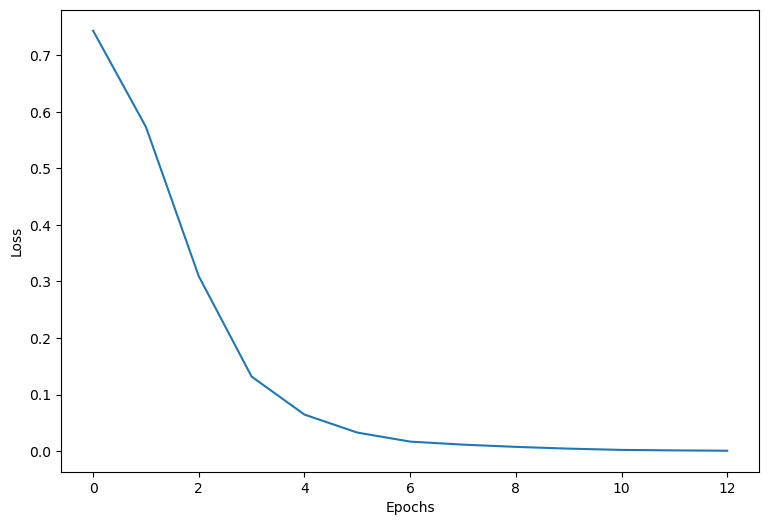

2024-05-01 17:17:59.767163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 17:17:59.768702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 17:17:59.770152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 17:17:59.771595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 17:17:59.785791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

2024-05-01 17:18:36.099663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-05-01 17:18:36.305098: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-05-01 17:18:36.513458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-05-01 17:18:36.721221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301


205/205 [==============================] - 80s 281ms/step - loss: 2.6721 - accuracy: 0.6485 - weighted_accuracy: 0.6080
FOLD 1 - male: Test accuracy: 64.85%
Test weighted accuracy: 60.80%
Test loss: 2.672097682952881


Getting predictions for test set: 100%|██████████| 205/205 [02:12<00:00,  1.54it/s]


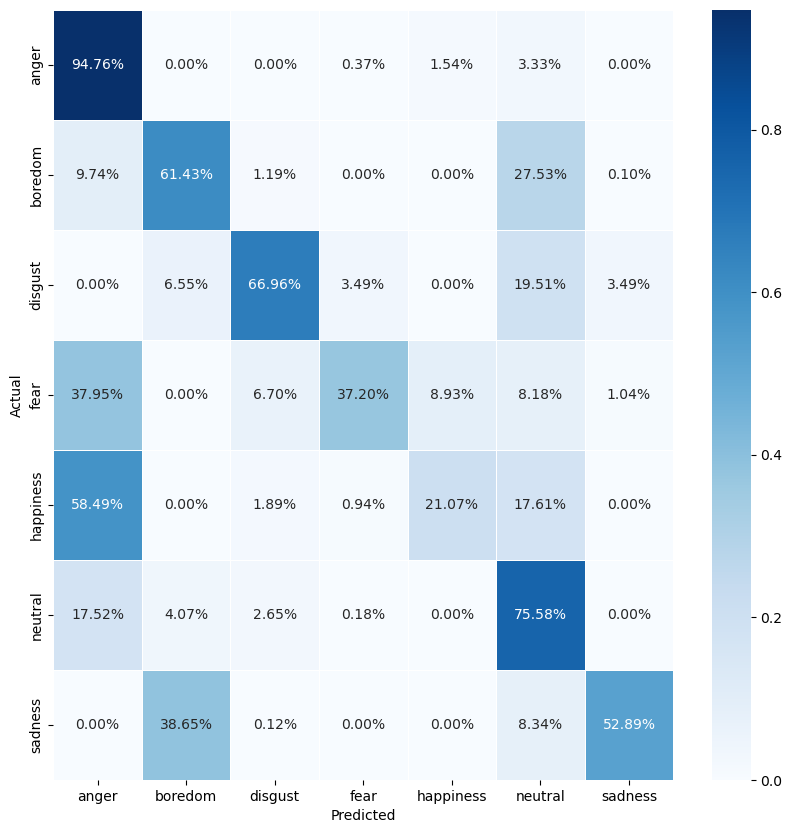

392/392 [==============================] - 111s 269ms/step - loss: 3.1923 - accuracy: 0.6798 - weighted_accuracy: 0.6107
FOLD 1 - female: Test accuracy: 67.98%
Test weighted accuracy: 61.07%
Test loss: 3.1922788619995117


Getting predictions for test set: 100%|██████████| 392/392 [04:06<00:00,  1.59it/s]


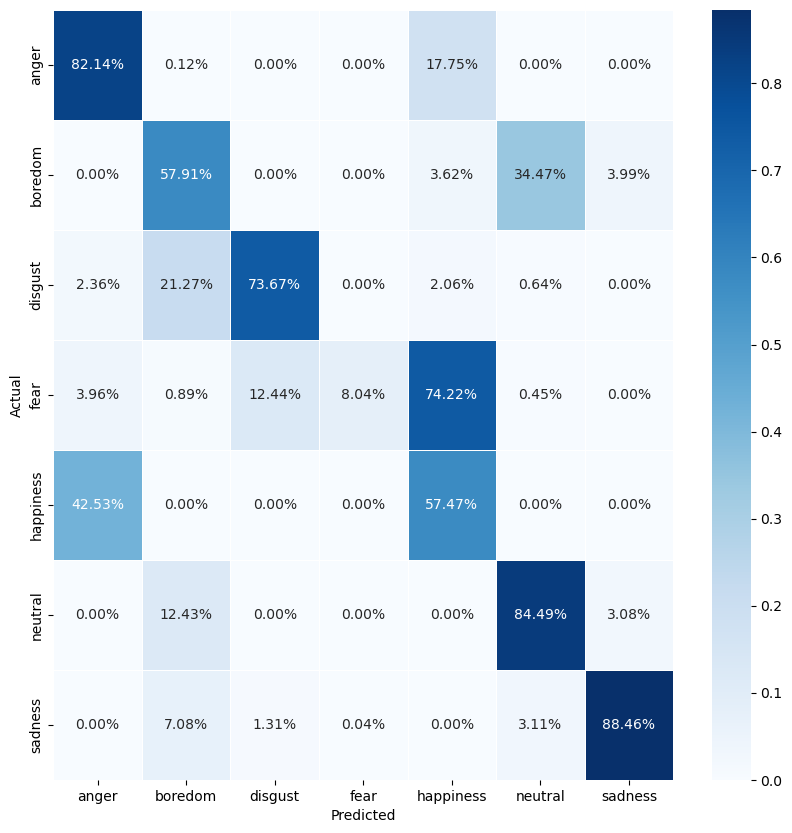


Fold 2:


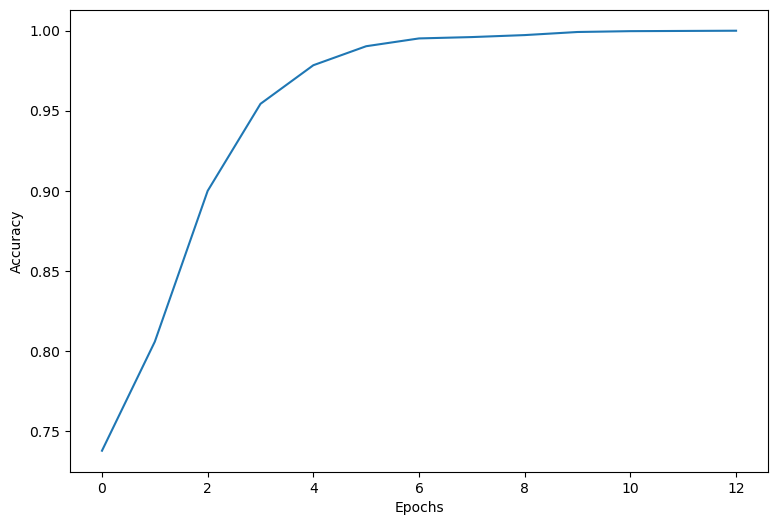

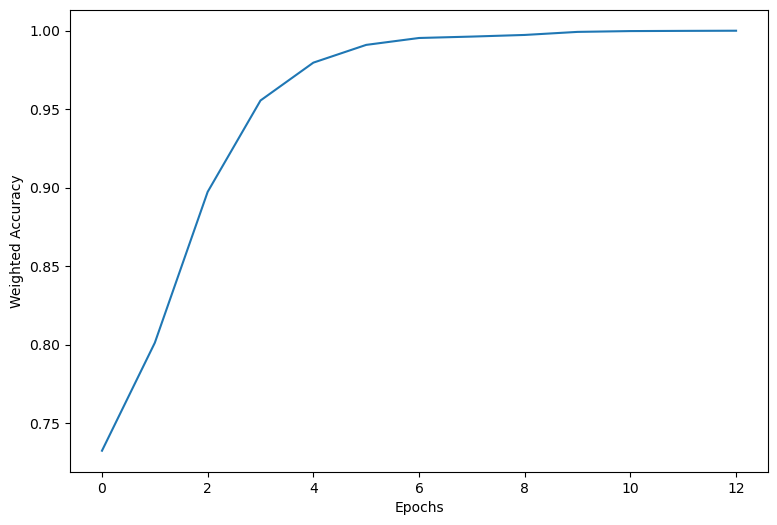

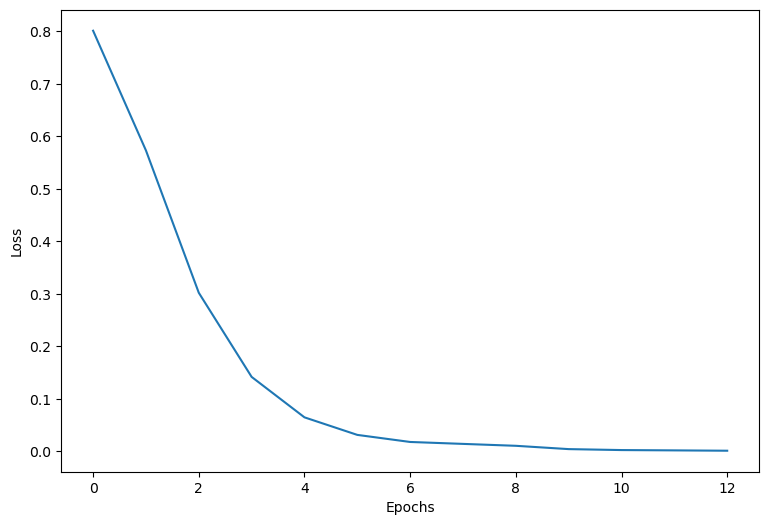

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
168/168 [==============================] - 49s 267ms/step - loss: 3.5111 - accuracy: 0.6252 - weighted_accuracy: 0.5906
FOLD 2 - male: Test accuracy: 62.52%
Test weighted accuracy: 59.06%
Test loss: 3.511117935180664


Getting predictions for test set: 100%|██████████| 168/168 [01:44<00:00,  1.61it/s]


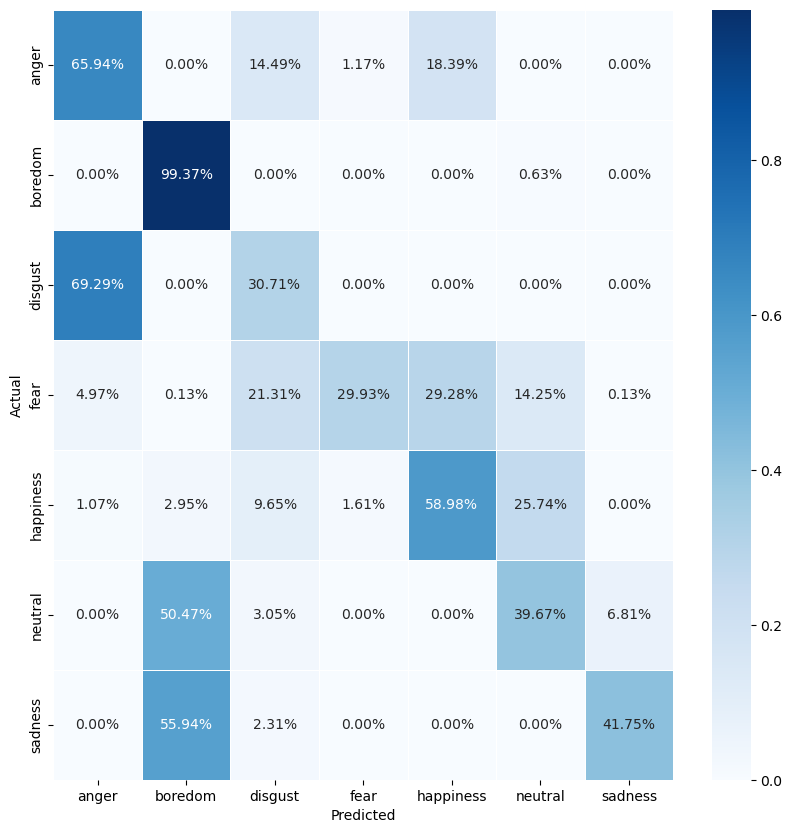

313/313 [==============================] - 89s 268ms/step - loss: 4.3671 - accuracy: 0.5926 - weighted_accuracy: 0.5845
FOLD 2 - female: Test accuracy: 59.26%
Test weighted accuracy: 58.45%
Test loss: 4.367079734802246


Getting predictions for test set: 100%|██████████| 313/313 [03:15<00:00,  1.60it/s]


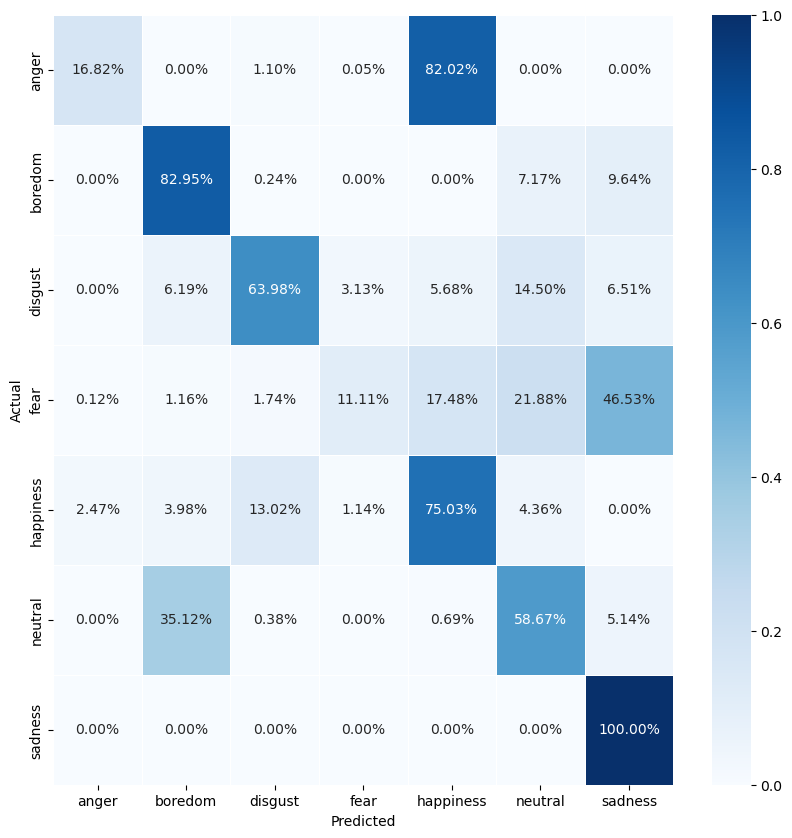


Fold 3:


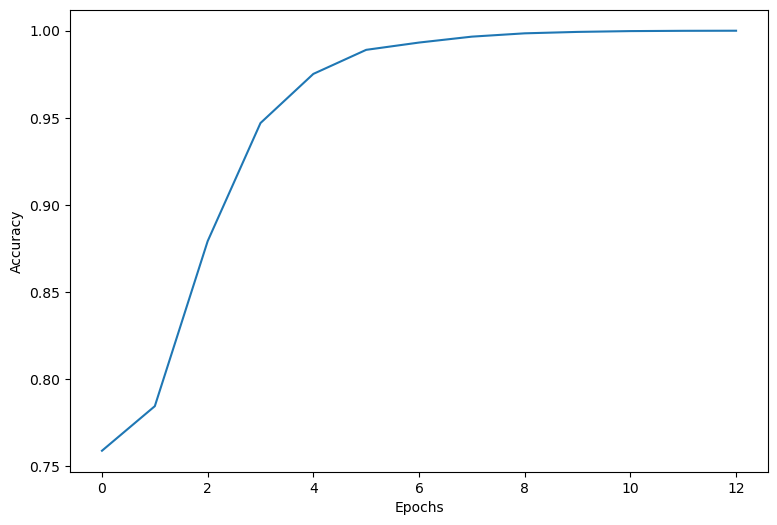

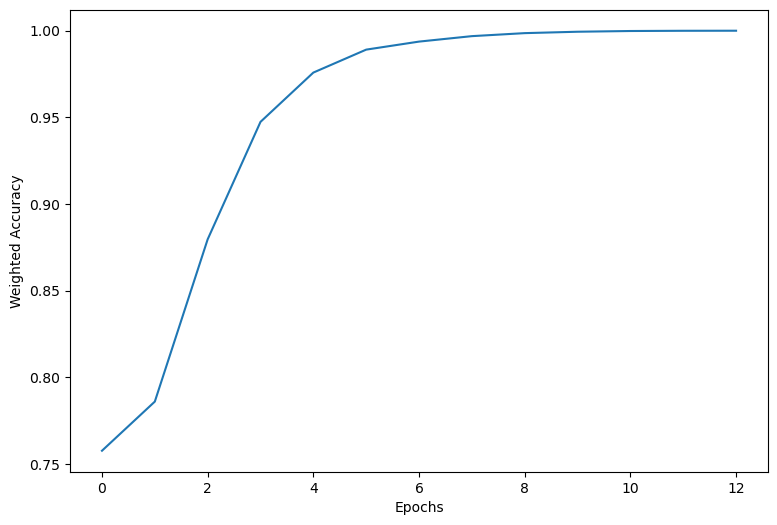

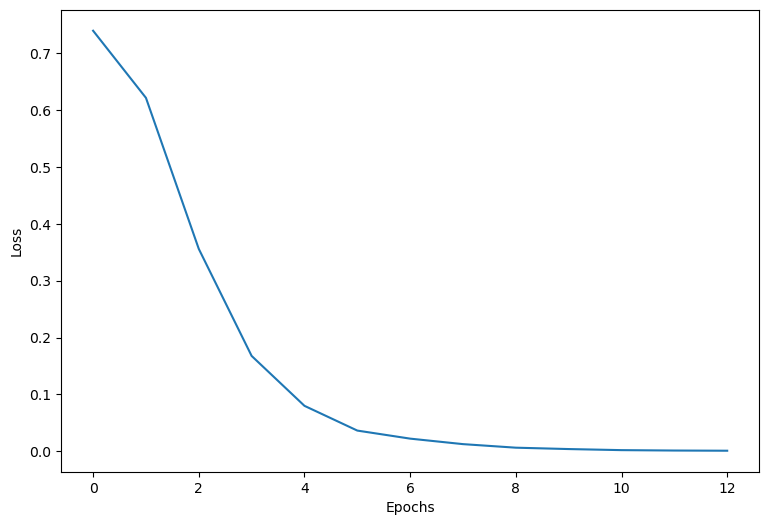

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
326/326 [==============================] - 93s 272ms/step - loss: 4.5577 - accuracy: 0.5720 - weighted_accuracy: 0.5039
FOLD 3 - male: Test accuracy: 57.20%
Test weighted accuracy: 50.39%
Test loss: 4.5577287673950195


Getting predictions for test set: 100%|██████████| 326/326 [03:21<00:00,  1.62it/s]


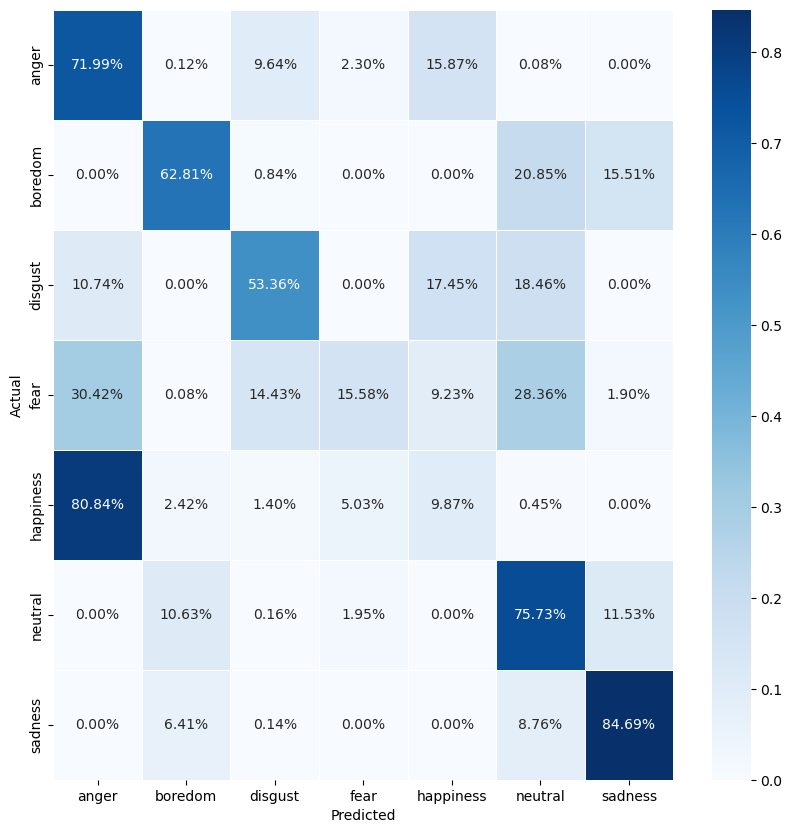

376/376 [==============================] - 106s 268ms/step - loss: 3.3621 - accuracy: 0.6612 - weighted_accuracy: 0.6079
FOLD 3 - female: Test accuracy: 66.12%
Test weighted accuracy: 60.79%
Test loss: 3.3620712757110596


Getting predictions for test set: 100%|██████████| 376/376 [03:58<00:00,  1.58it/s]


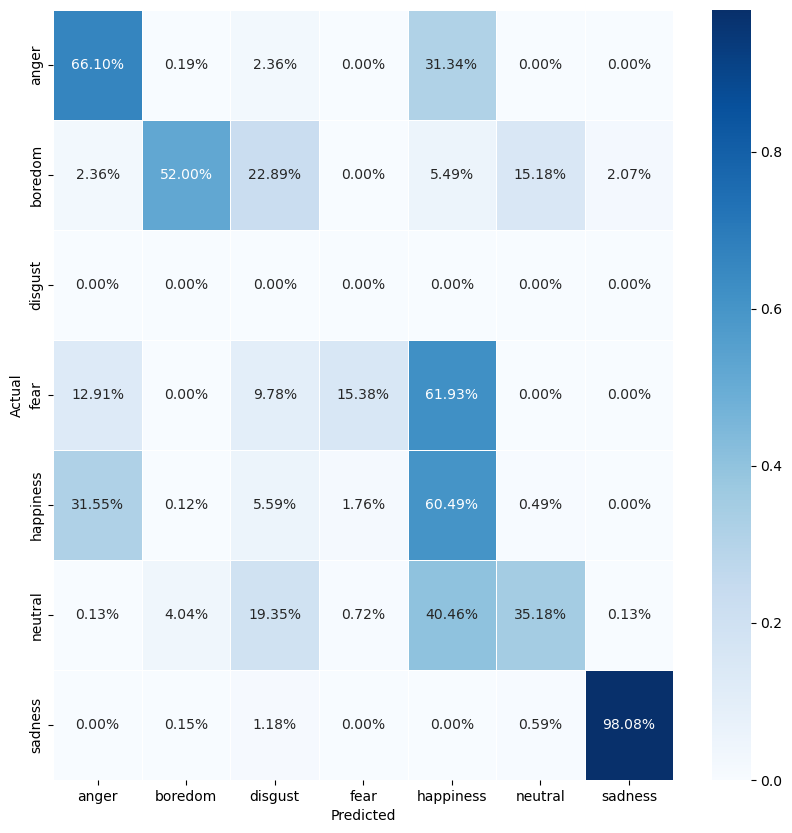


Fold 4:


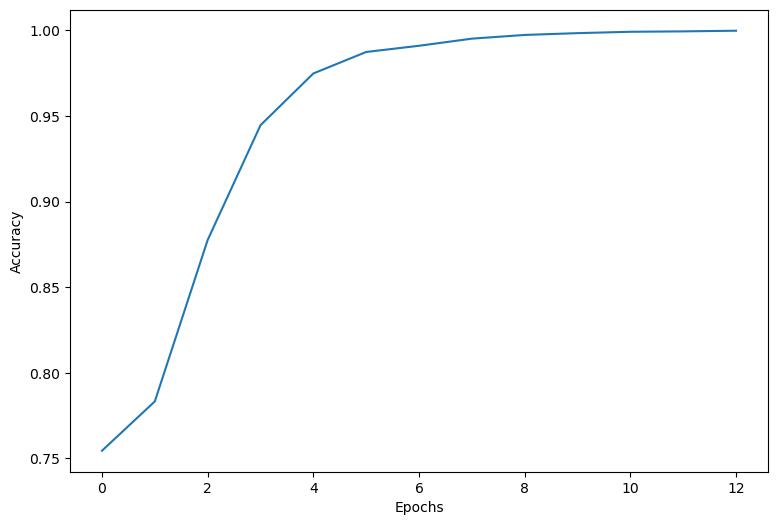

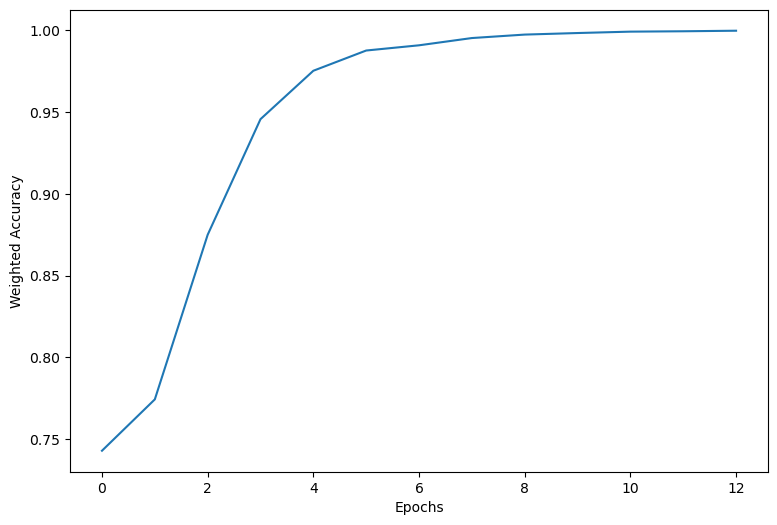

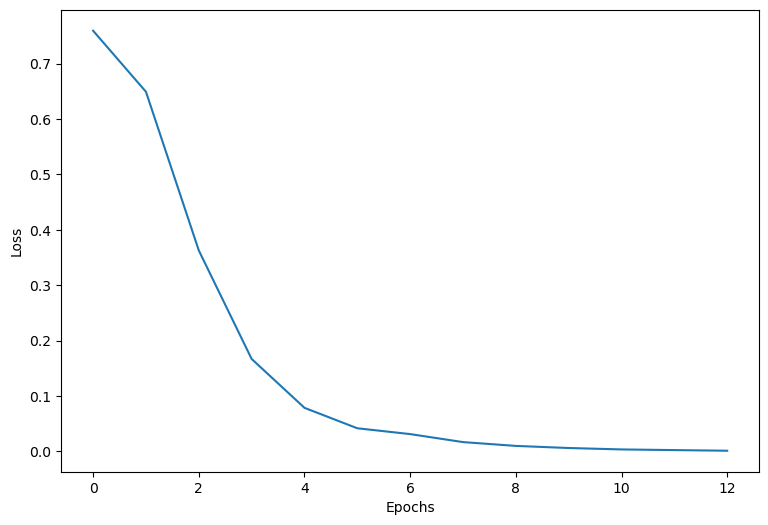

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
264/264 [==============================] - 74s 265ms/step - loss: 5.7995 - accuracy: 0.5802 - weighted_accuracy: 0.4972
FOLD 4 - male: Test accuracy: 58.02%
Test weighted accuracy: 49.72%
Test loss: 5.79951810836792


Getting predictions for test set: 100%|██████████| 264/264 [02:44<00:00,  1.60it/s]


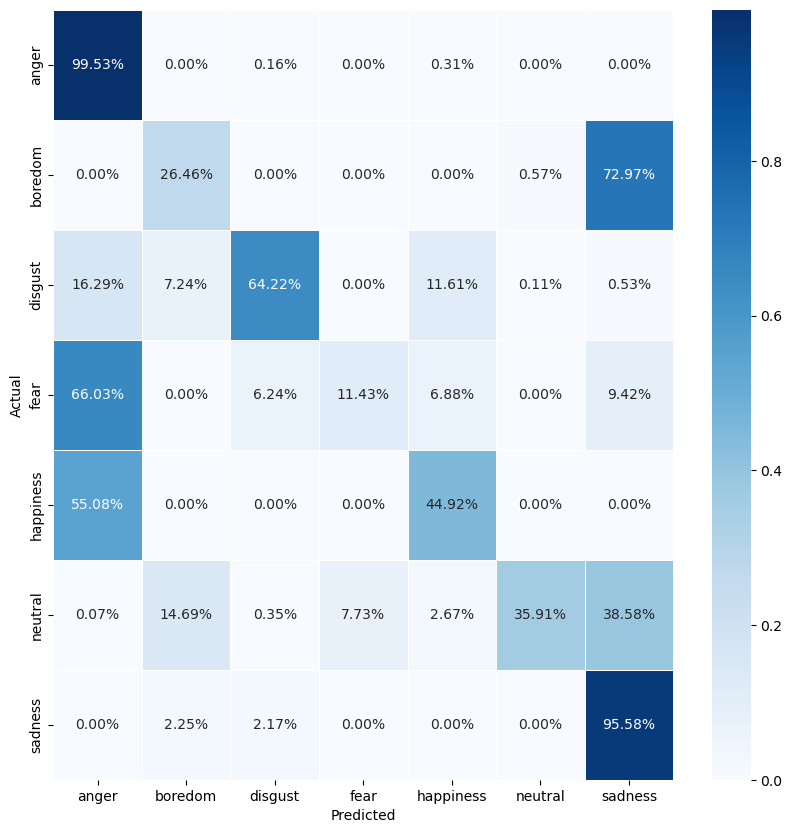

458/458 [==============================] - 125s 263ms/step - loss: 5.1442 - accuracy: 0.5365 - weighted_accuracy: 0.5008
FOLD 4 - female: Test accuracy: 53.65%
Test weighted accuracy: 50.08%
Test loss: 5.144176959991455


Getting predictions for test set: 100%|██████████| 458/458 [04:43<00:00,  1.62it/s]


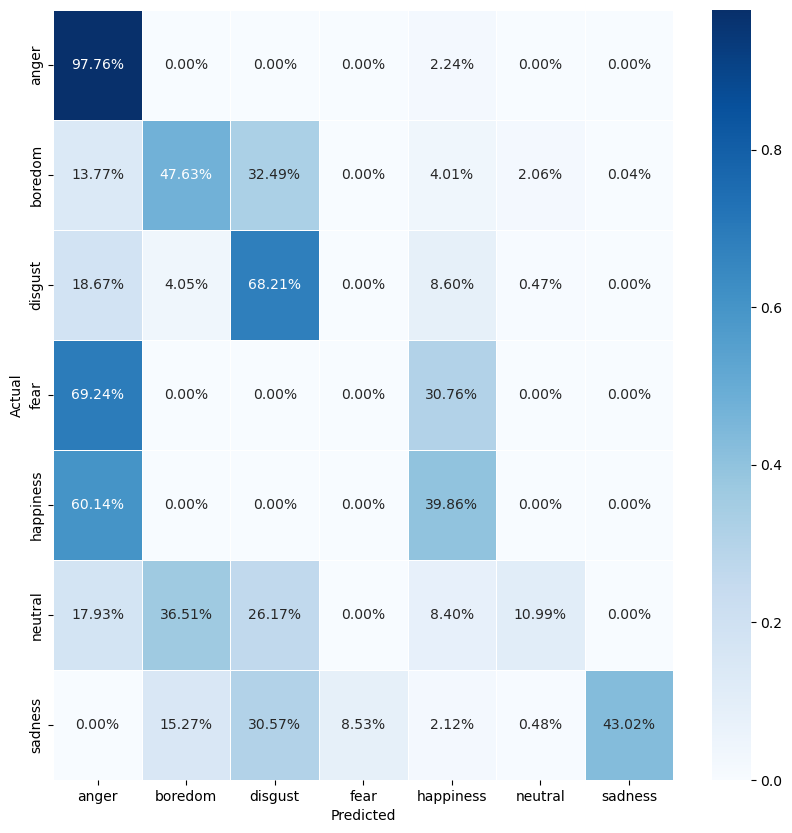


Fold 5:


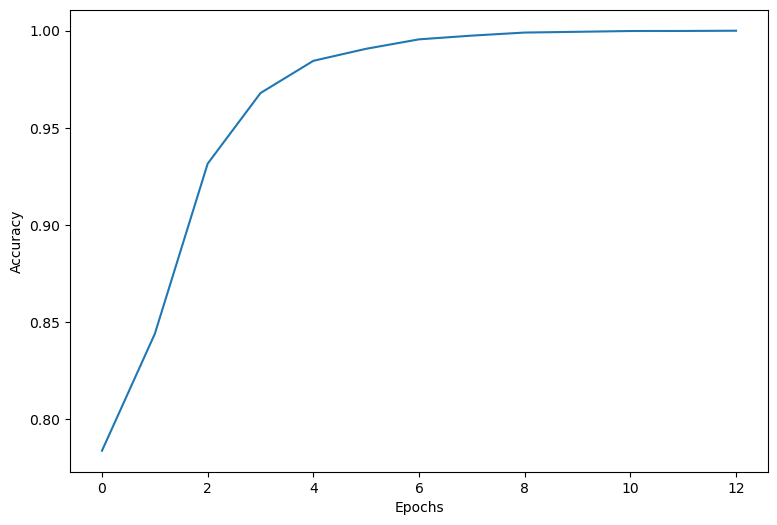

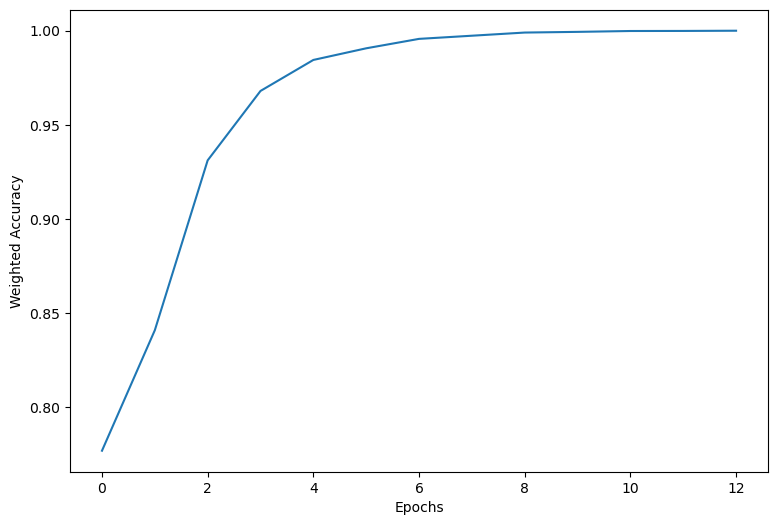

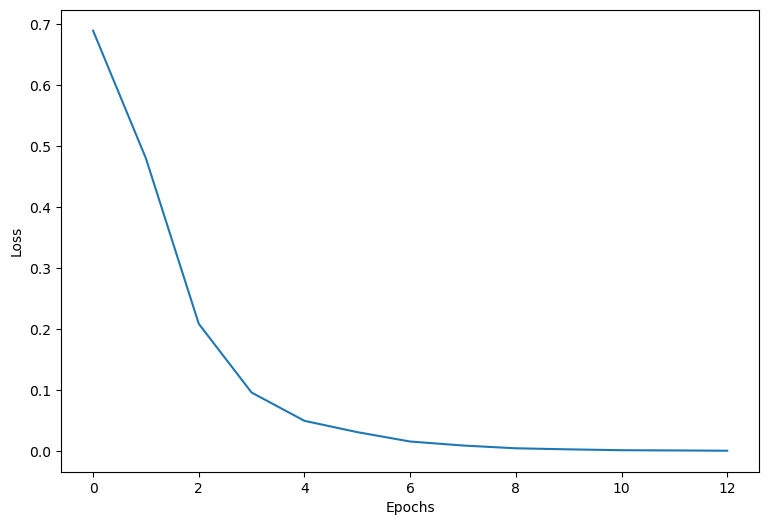

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
253/253 [==============================] - 72s 268ms/step - loss: 2.8758 - accuracy: 0.6947 - weighted_accuracy: 0.6564
FOLD 5 - male: Test accuracy: 69.47%
Test weighted accuracy: 65.64%
Test loss: 2.8757851123809814


Getting predictions for test set: 100%|██████████| 253/253 [02:39<00:00,  1.59it/s]


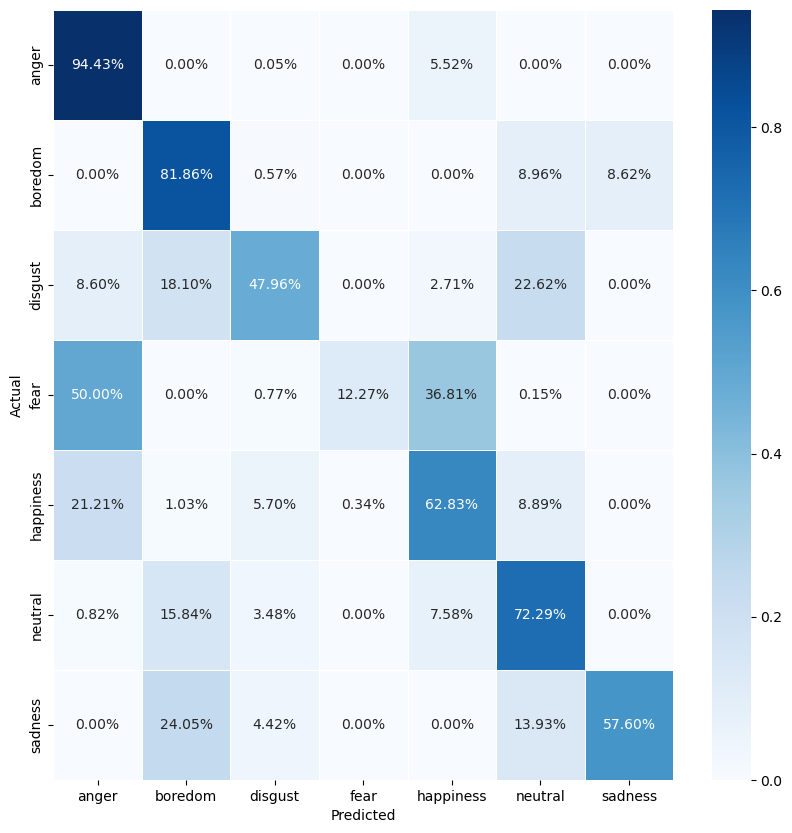

234/234 [==============================] - 68s 267ms/step - loss: 3.8055 - accuracy: 0.6005 - weighted_accuracy: 0.5605
FOLD 5 - female: Test accuracy: 60.05%
Test weighted accuracy: 56.05%
Test loss: 3.8055131435394287


Getting predictions for test set: 100%|██████████| 234/234 [02:27<00:00,  1.58it/s]


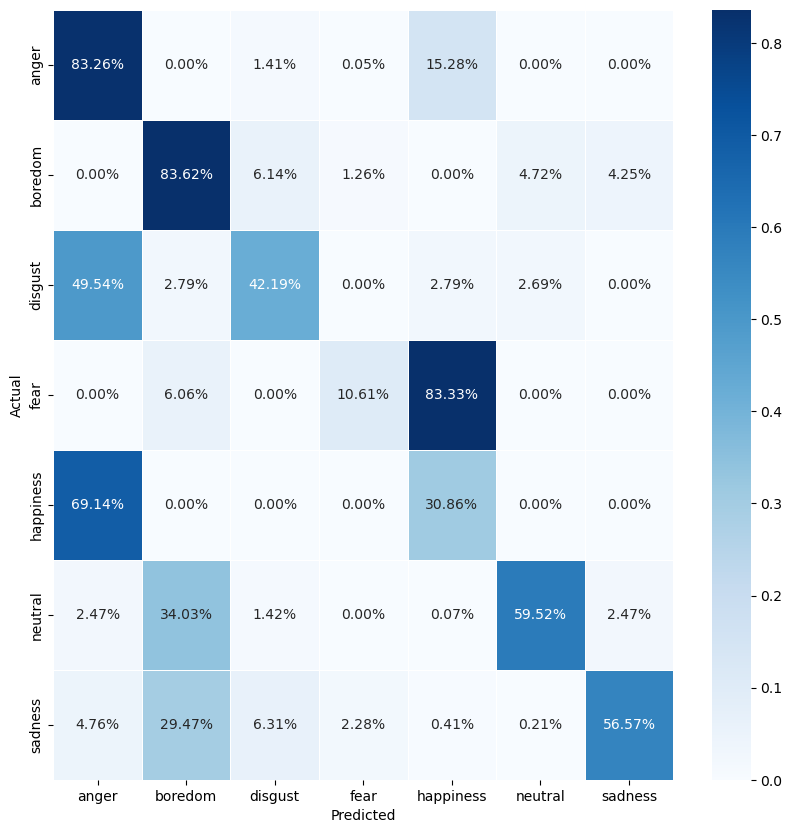

In [25]:
test_cv_results = []
test_cv_results_gendered = {"male": [], "female": []}
genders = ["male", "female"]
for fold, (test_df_male, test_df_female) in enumerate(zip(ser_df_male_parts, ser_df_female_parts)):
    test_df_dict = {"male": test_df_male, "female": test_df_female}
    print(f"\nFold {fold + 1}:")
    # train_dfs = [pd.concat([df_male, df_female], ignore_index=True) for idx, (df_male, df_female) in enumerate(zip(ser_df_male_parts, ser_df_female_parts)) if idx != fold]
    # train_df = pd.concat(train_dfs).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    ohe = joblib.load(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_ohe.pkl")))
    new_model_name = MODEL_NAME.replace(".h5", f"_fold_{fold + 1}.h5")
    plot_training_curve(new_model_name)
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        for gender in genders:
            new_tfrecords_name = TF_RECORDS_NAME.replace(".tfrecords", f"_fold_{fold + 1}_{gender}.tfrecords")
            test_dataset = get_dataset(os.path.join(TF_RECORDS_DIR, "test", new_tfrecords_name), BATCH_SIZE, dataset_type="test")
            model = load_model(os.path.join(MODEL_DIR, new_model_name))
            results_test = model.evaluate(test_dataset, workers=12, use_multiprocessing=True)
            test_cv_results.append(results_test)
            test_cv_results_gendered[gender].append(results_test)
            print(f"FOLD {fold + 1} - {gender}: Test accuracy: {results_test[1]:0.2%}\nTest weighted accuracy: {results_test[2]:0.2%}\nTest loss: {results_test[0]}")
            # plot confusion matrix
            test_dataset_slices = list(test_dataset.as_numpy_iterator())
            x_true = np.concatenate([batch[0] for batch in test_dataset_slices], axis=0)
            y_true = np.concatenate([batch[1] for batch in test_dataset_slices], axis=0)
            test_sample_weight = np.concatenate([batch[2] for batch in test_dataset_slices], axis=0)
            for i in tqdm(range(0, x_true.shape[0], BATCH_SIZE), desc="Getting predictions for test set"):
                if i == 0:
                    y_pred = model.predict(x_true[i:i+BATCH_SIZE], verbose=0)
                else:
                    y_pred = np.concatenate((y_pred, model.predict(x_true[i:i+BATCH_SIZE], verbose=0)), axis=0)
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y_true, axis=1)
            confusion_mat = confusion_matrix(y_true, y_pred, normalize="true")
            plt.figure(figsize=(10, 10))
            sns.heatmap(confusion_mat, annot=True, fmt=".2%", xticklabels=ohe.categories_[0], yticklabels=ohe.categories_[0], cmap="Blues", linewidths=0.5)
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()

In [26]:
# Print the average results of the folds
print(f"Average results of the folds on both genders:")
print(f"Test accuracy: {np.mean([result[1] for result in test_cv_results]):0.2%}")
print(f"Test weighted accuracy: {np.mean([result[2] for result in test_cv_results]):0.2%}")
print(f"Test loss: {np.mean([result[0] for result in test_cv_results])}")

Average results of the folds on both genders:
Test accuracy: 61.91%
Test weighted accuracy: 57.20%
Test loss: 3.928736758232117


In [27]:
# Print the average results of the folds on gender
for gender in ["male", "female"]:
    print(f"Average results of the folds on {gender}")
    print(f"Test accuracy: {np.mean([result[1] for result in test_cv_results_gendered[gender]]):0.2%}")
    print(f"Test weighted accuracy: {np.mean([result[2] for result in test_cv_results_gendered[gender]]):0.2%}")
    print(f"Test loss: {np.mean([result[0] for result in test_cv_results_gendered[gender]])}")

Average results of the folds on male
Test accuracy: 62.41%
Test weighted accuracy: 57.12%
Test loss: 3.883249521255493
Average results of the folds on female
Test accuracy: 61.41%
Test weighted accuracy: 57.29%
Test loss: 3.97422399520874
